# Packages

In [1]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn
random.seed(1234)

# Dataset

In [2]:
batchsize = 2000

In [3]:
train = torchvision.datasets.FashionMNIST(root = './', train = True, download = True, transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), #torchvision.transforms.Normalize((trainmean,), (trainstd,))                                 
    ])
)
trainshuffled = torch.utils.data.DataLoader(train, batch_size=60000, shuffle=True) 
train_labels = trainshuffled.dataset.targets
train_data = trainshuffled.dataset.data

#FOR MLP 
train_dataloader = DataLoader(train, batch_size=60000, shuffle=True)
train_x, train_y = next(iter(train_dataloader))
print(f"Feature batch shape: {train_x.size()}")
print(f"Labels batch shape: {train_y.size()}")
#NICHOLAS USE THESE FOR TRAINING
xtrain = np.array(train_x.squeeze()).reshape(60000, 28*28)
ytrain = np.array(train_y)

#FOR CNN
train_dataloader = DataLoader(train, batch_size=batchsize, shuffle=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw

Feature batch shape: torch.Size([60000, 1, 28, 28])
Labels batch shape: torch.Size([60000])


In [4]:
test = torchvision.datasets.FashionMNIST(root = './', train = False, download = True, transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), #torchvision.transforms.Normalize((testmean,), (teststd,))                                 
    ])
)
testshuffled = torch.utils.data.DataLoader(test, batch_size=60000, shuffle=True) 
test_labels = testshuffled.dataset.targets
test_data = testshuffled.dataset.data

#FOR MLP 
test_dataloader = DataLoader(test, batch_size=60000, shuffle=True)
test_x, test_y = next(iter(test_dataloader))
print(f"Feature batch shape: {test_x.size()}")
print(f"Labels batch shape: {test_y.size()}")
#NICHOLAS USE THESE FOR TRAINING
xtest = np.array(test_x.squeeze()).reshape(10000, 28*28)
ytest = np.array(test_y)


#For CNN
test_dataloader = DataLoader(test, batch_size=10000, shuffle=False)

Feature batch shape: torch.Size([10000, 1, 28, 28])
Labels batch shape: torch.Size([10000])


In [5]:
print("train label distribution" , np.bincount(ytrain))
print("test label distribution" , np.bincount(ytest))

train label distribution [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
test label distribution [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


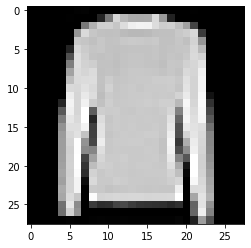

In [28]:
imgplot = plt.imshow(train_x[68].squeeze(),cmap='gray')

# MLP

## Activations

In [ ]:
def softmax(input):
  # input -= np.max(input)
  # output = []
  # for col in input.T:
  #     sum = np.sum(np.exp(col))
  #     output_col = []
  #     for element in col:
  #       output_col.append(np.exp(element) / sum)
  #     output.append(output_col)
  # return np.array(output).T
  input -= np.max(input)
  log_output = []
  for col in input.T:
      log_sum = np.log(np.sum(np.exp(col)))
      output_col = []
      for element in col:
        output_col.append(element - log_sum)
      log_output.append(output_col)
  return np.exp(np.array(log_output).T)

def activation(array, activation=None):
  if(activation == "relu"):
      return np.maximum(np.zeros(array.shape), array)

  elif(activation == "tanh"):
    return np.tanh(array)

  elif(activation == "leaky-relu"):
    leaky_relu_coef = 0.001
    return np.maximum(leaky_relu_coef * array, array)

  elif(activation == "sigmoid"):
    return (1 / (1 + np.exp(-array)))

  else:
    return array  # Pass through activation

def derivative_activation(array, activation=None):
  if(activation == "relu"):
      return np.where(array > 0, 1, 0)

  elif(activation == "tanh"):
    return (1 - np.tanh(array)*np.tanh(array))

  elif(activation == "leaky-relu"):
    leaky_relu_coef = 0.001
    return np.where(array > 0, 1, leaky_relu_coef)

  elif(activation == "sigmoid"):
    return (1 / (1 + np.exp(-array))) * (1 - (1 / (1 + np.exp(-array))))

  else:
    return 1

##MLP Class

In [ ]:
class mlp:
  def __init__(self, x, y, num_hidden_layers, M):
    # self.task = task
    self.num_hidden_layeres = num_hidden_layers
    self.M = M
    self.N = x.shape[0]
    self.D = x.shape[1]
    self.C = y.shape[1]
    if(self.N != y.shape[0]):
      raise("Dimension mismatch!")
    
  def fit(self, x, y, optimizer):
    N, D = x.shape
    def gradient(x, y, params):
      # v = params[0]  # PART 1
      # dparams = []

      v, w = params  # PART 2
      q = np.dot(x, v)
      z = activation(q, "relu")
      u = np.dot(z,w)
      yh = softmax(u)
      dy = yh - y
      dw = np.dot(z.T, dy)/N

      # dz = np.dot(dy, w.T)
      dz = np.outer(dy, w)
      print("dz shape: " + str(dz.shape))
      print("dz shape: " + str(dz.shape))

      dv = np.dot(x.T, dz * derivative_activation(q, "relu"))/N  # PROBLEM HERE

      dparams = [dv, dw]

      # v, w, t = params  # PART 3
      # dparams = []
      return dparams

    # No hidden layers --> PART 1
    # v = np.random.randn(self.task.get_num_outputs, self.task.get_num_inputs) * 0.01
    # self.params0 = [v]

    # Two hidden layers --> Part 3
    # v = np.random.randn(self.task.get_num_inputs, self.M[0]) * 0.01
    # w = np.random.rand(self.M[0], self.M[1]) * 0.01
    # t = np.random.rand(self.M[1], self.task.get_num_outputs) * 0.01
    # self.params0 = [v,w,t]

    # One hidden layer --> PART 2
    v = np.random.randn(self.D, self.M[0]) * 0.1
    w = np.random.randn(self.M[0], self.C) * 0.1
    params0 = [v,w]

    self.params = optimizer.run(gradient, x, y, params0)
    return self

  def predict(self, x):
      v, w = self.params  # PART 2
      q = np.dot(x, v)
      z = activation(q, "relu")
      u = np.dot(z,w)
      yh = softmax(u)
      return yh

## Gradient Descent

In [ ]:
class GradientDescent:
    def __init__(self, learning_rate=.001, max_iters=1e5, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, params):
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params)
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params

In [ ]:
#MLP INPUTS these are all np array that are vectorize
print(xtrain.shape)

temp = [[0,0,0,0,0,0,0,0,0,0] for _ in range(ytrain.shape[0])]
for row_number, row_value in enumerate(ytrain):
  temp[row_number][row_value] = 1
ytrain_hot = np.array(temp)

print(ytrain_hot.shape)
print(xtest.shape)
print(ytest.shape)

In [ ]:
print(ytrain)
print(xtrain)

print(len(xtrain[0]))

In [ ]:
x = xtrain
y = ytrain_hot

model = mlp(x, y, num_hidden_layers=1, M=[128])
optimizer = GradientDescent(learning_rate=.1, max_iters=20000)
yh = model.fit(x, y, optimizer).predict(x)

In [ ]:
print(yh)
print(np.min(yh))

#CNN

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 8, 4)
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 10)
        #self.fc3 = nn.Linear(128, 10)

    def forward(self, x):

      x = self.pool(F.relu(self.conv1(x)))

      x = self.pool(F.relu(self.conv2(x)))

      x = torch.flatten(x, 1) # flatten all dimensions except batch
      
      x = F.relu(self.fc1(x))

      #x = F.relu(self.fc2(x))

      x = self.fc2(x)
      #x = self.fc3(x)
      return x




In [13]:


lr = 0.001
momentum = 0.9
epochs = 1

def trainPredictCNN(lr=0.001, epochs = 100,batchsize = 2000, optimizerChoice = 'Adam'):
  
  #create data loaders with specified batch size 
  train_dataloader = DataLoader(train, batch_size=batchsize, shuffle=True)
  test_dataloader = DataLoader(test, batch_size=10000, shuffle=False)
  
  #for using gpu
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  #print(device)

  
  net = CNN()
  net.to(device)
  ce = nn.CrossEntropyLoss()
  if optimizerChoice == 'Adam':
    optimizer = optim.Adam(net.parameters(), lr=lr)
  
  elif optimizerChoice == 'sgd':
    optimizer = optim.SGD(net.parameters(), lr=lr,momentum=0.9)

  elif optimizerChoice == 'ada':
    optimizer = optim.Adagrad(net.parameters(), lr=lr)

  e = 0
  for epoch in range(epochs):
    eloss = 0.0
    right = 0
    #Loop through each batch of training set
    for data in train_dataloader:
        x, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        #forward propagation 
        pred = net(x)

        #Calculate Cross entropy loss
        loss = ce(pred, y)

        #Run backpropagation
        loss.backward()

        #Optimize weights
        optimizer.step()

        #Add loss of current batch to epoch loss
        eloss += loss.item()
        
        
        s, predicted = torch.max(pred.data, 1)
        right += (predicted == y).sum().item()

    trainacc = right / 60000 * 100
    #print("epoch " + str(e) + " loss: " + str(eloss) + "accuracy: " , trainacc)
    e +=1
  #print('Finished Training')


  #print accuracy on test set
  right = 0

  with torch.no_grad():
      for data in test_dataloader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = net(images)
          #argmax on predictions
          s, predicted = torch.max(outputs.data, 1)
          right += (predicted == labels).sum().item()
        


          #For plotting confusion matrix
          if 0: 
            y_true = labels.tolist()
            y_pred = predicted.tolist()
            confusion = confusion_matrix(y_true, y_pred)
            confusionDF = pd.DataFrame(confusion, index = test_dataloader.dataset.classes,
                            columns = test_dataloader.dataset.classes)
            plt.figure(figsize = (20,14))
            sn.heatmap(confusionDF, annot=True)
  acc = right / 10000 * 100
  print('Test Accuracy: ' , acc)

  
  return acc


In [14]:
#to generate confusion matrix and get accuracy with best hyperparams
acc = trainPredictCNN(epochs=250,lr=0.005,batchsize=200)
print(acc)

epoch 0 loss: 210.11766782402992accuracy:  74.08166666666666
epoch 1 loss: 135.7685346007347accuracy:  83.705
epoch 2 loss: 118.88887006044388accuracy:  85.61333333333333
epoch 3 loss: 109.35671569406986accuracy:  86.68333333333334
epoch 4 loss: 102.73652118444443accuracy:  87.41333333333333
epoch 5 loss: 99.25679625570774accuracy:  87.93833333333333
epoch 6 loss: 94.93816588819027accuracy:  88.255
epoch 7 loss: 92.99227423965931accuracy:  88.57166666666667
epoch 8 loss: 88.56239852309227accuracy:  89.08666666666667
epoch 9 loss: 85.99670740962029accuracy:  89.23666666666666
epoch 10 loss: 85.54280127584934accuracy:  89.35499999999999
epoch 11 loss: 82.6100530475378accuracy:  89.685
epoch 12 loss: 82.60158021748066accuracy:  89.735
epoch 13 loss: 80.25380021333694accuracy:  89.91
epoch 14 loss: 78.23809014260769accuracy:  90.24166666666666
epoch 15 loss: 76.92625053226948accuracy:  90.34
epoch 16 loss: 74.87912811338902accuracy:  90.64833333333333
epoch 17 loss: 73.60158985853195accura

###Crossvalidation

In [ ]:
learning_rates = [0.001,0.005,0.01]
epochchoices = [50,100,250,500]
#epochchoices = [1]
batchchoice = [200,2000,5000,60000]
optimizerchoice = ['Adam','ada','sgd']

results = []
for l in learning_rates:
  for e in epochchoices:
    for b in batchchoice:
      for o in optimizerchoice:
        testacc = trainPredictCNN(lr = l, epochs = e, batchsize = b, optimizerChoice = o)
        res = [testacc,l,e,b,o]
        results.append(res)
        print('Test accuracy: ', testacc, " with lr = ", l , " epochs = ", e, " optimizer = ", o, "batchsize = ", b)




In [ ]:
df = pd.DataFrame(results, columns =['Accuracy', 'LR', 'Epochs','Optimizer','Batchsize']) 
df.to_csv('cnncv.csv')

In [ ]:
results

In [ ]:
learning_rates = [0.001,0.005,0.01]
epochchoices = [50,100,250,500]
#epochchoices = [1]
batchchoice = [200,2000,5000,60000]
optimizerchoice = ['Adam','ada','sgd']

results = []
for o in optimizerchoice:
        testacc = trainPredictCNN(lr = 0.001, epochs = 50, batchsize = 2000, optimizerChoice = o)
        #res = [testacc,l,e,b,o]
        #results.append(res)
        print('Test accuracy: ', testacc, " with lr = ", 0.001 , " epochs = ", 50, " optimizer = ", o, "batchsize = ", 2000)


Test accuracy:  86.63  with lr =  0.001  epochs =  50  optimizer =  Adam batchsize =  2000
Test accuracy:  72.67  with lr =  0.001  epochs =  50  optimizer =  ada batchsize =  2000
Test accuracy:  72.61  with lr =  0.001  epochs =  50  optimizer =  sgd batchsize =  2000


In [ ]:
learning_rates = [0.001,0.005,0.01]
epochchoices = [50,100,250,500]
#epochchoices = [1]
batchchoice = [200,2000,5000,60000]
optimizerchoice = ['Adam','ada','sgd']

results = []
for b in batchchoice:
        testacc = trainPredictCNN(lr = 0.001, epochs = 50, batchsize = b, optimizerChoice = 'Adam')
        #res = [testacc,l,e,b,o]
        #results.append(res)
        print('Test accuracy: ', testacc, " with lr = ", 0.001 , " epochs = ", 50, " optimizer = Adam", "batchsize = ", b)

Test accuracy:  88.28  with lr =  0.001  epochs =  50  optimizer = Adam batchsize =  200
Test accuracy:  85.32  with lr =  0.001  epochs =  50  optimizer = Adam batchsize =  2000
Test accuracy:  84.24000000000001  with lr =  0.001  epochs =  50  optimizer = Adam batchsize =  5000


In [ ]:
learning_rates = [0.001,0.005,0.01]
epochchoices = [50,100,250,500]
#epochchoices = [1]
batchchoice = [200,2000,5000,60000]
optimizerchoice = ['Adam','ada','sgd']

results = []
for l in learning_rates:
        testacc = trainPredictCNN(lr = l, epochs = 50, batchsize = 2000, optimizerChoice = 'Adam')
        #res = [testacc,l,e,b,o]
        #results.append(res)
        print('Test accuracy: ', testacc, " with lr = ", l , " epochs = ", 50, " optimizer = Adam", "batchsize = 2000")

Test accuracy:  86.55000000000001  with lr =  0.001  epochs =  50  optimizer = Adam batchsize = 2000
Test accuracy:  88.56  with lr =  0.005  epochs =  50  optimizer = Adam batchsize = 2000
Test accuracy:  88.26  with lr =  0.01  epochs =  50  optimizer = Adam batchsize = 2000


In [ ]:
learning_rates = [0.001,0.005,0.01]
epochchoices = [50,100,250,500]
#epochchoices = [1]
batchchoice = [200,2000,5000,60000]
optimizerchoice = ['Adam','ada','sgd']

results = []
for e in epochchoices:
        testacc = trainPredictCNN(lr = 0.001, epochs = e, batchsize = 2000, optimizerChoice = 'Adam')
        #res = [testacc,l,e,b,o]
        #results.append(res)
        print('Test accuracy: ', testacc, " with lr = 0.01" , " epochs = ", e, " optimizer = Adam", "batchsize = 2000")

Test accuracy:  86.03  with lr = 0.01  epochs =  50  optimizer = Adam batchsize = 2000
Test accuracy:  87.17  with lr = 0.01  epochs =  100  optimizer = Adam batchsize = 2000
Test accuracy:  88.07000000000001  with lr = 0.01  epochs =  250  optimizer = Adam batchsize = 2000
Test accuracy:  88.8  with lr = 0.01  epochs =  500  optimizer = Adam batchsize = 2000


In [ ]:
testacc = trainPredictCNN(lr = 0.005, epochs = 250, batchsize = 200, optimizerChoice = 'Adam')
print('Test accuracy: ', testacc, " with lr = 0.005" , " epochs = ", 200, " optimizer = Adam", "batchsize = 200")